<a href="https://colab.research.google.com/github/gtrujillop-bl/presupuesto_analytics/blob/master/CnnVascularCalcification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! [ -e /content ] && pip install -Uqq pydicom
! [ -e /content ] && pip install efficientnet_pytorch




     |████████████████████████████████| 2.0 MB 14.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c124786077a730c5e374e11eab8716fa149a048dde4b56a25fb0929867836228
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from google.colab import drive
import torch
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pydicom
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
from scipy import ndimage
from skimage import morphology

print(torch.cuda.get_device_name(0))

drive.mount('/content/drive')


Tesla P100-PCIE-16GB
Mounted at /content/drive


In [ ]:
from PIL import Image
from torch.utils import data
# !unzip -uq "/content/drive/My Drive/Master UNIR/TFM/RxImagesMay2017Anonymised.zip" -d "/content/drive/My Drive/Master UNIR/TFM/RxImagesMay2017Anonymised"
import os
import random
import torchvision
from torchvision import transforms as T
from torchvision.io import read_image
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

full_spine_images_dir = '/content/drive/My Drive/Master UNIR/TFM/lateral full-spine x-ray dataset/'
full_spine_image_filenames = [name for name in os.listdir(full_spine_images_dir) if os.path.splitext(name)[-1] == '.jpg']

batch_size = len(full_spine_image_filenames)
print(batch_size)

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

image = Image.open("/content/drive/My Drive/Master UNIR/TFM/lateral full-spine x-ray dataset/000080.jpg").convert('RGB')


99


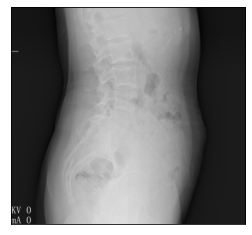

In [ ]:
to_tensor = T.Compose([
    T.ToTensor()
])
rx_as_tensor = to_tensor(image)
cropped_rx = torchvision.transforms.functional.crop(rx_as_tensor, 3600,0, 2600, 2800)
rx_transforms = T.Compose([
    T.Resize(256)    
])
transformed_rx = rx_transforms(cropped_rx)
show([cropped_rx])

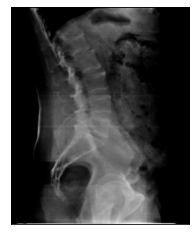

In [ ]:
dicom_image = pydicom.dcmread("/content/drive/My Drive/Master UNIR/TFM/DICOM/I0")
jpg_dicom_image = dicom_image.pixel_array.astype(float)
scaled_image = (np.maximum(jpg_dicom_image, 0) / jpg_dicom_image.max()) * 255.0
scaled_image = np.uint8(scaled_image)
final_dicom_image = Image.fromarray(scaled_image).convert('RGB')
transforms = T.Compose([
    T.Resize(256),
    T.ToTensor()    
])
transformed_dicom_imag = transforms(final_dicom_image)
show([transformed_dicom_imag])




In [ ]:
BATCH_SIZE = 30

def image_loader(filepath):
    # Converts any image to tensor first to apply initial transformations
    transforms = T.Compose([
      T.ToTensor()    
    ])
    # attempts to load a jpg and crops it
    try:
      img = Image.open(filepath).convert('RGB')
      rx_as_tensor = transforms(img)
      cropped_rx = torchvision.transforms.functional.crop(rx_as_tensor, 3600,0, 2600, 2800)
      return cropped_rx
    # otherwise, loads a DICOM image
    except:
      dicom_image = pydicom.dcmread(filepath, force=True)
      jpg_dicom_image = dicom_image.pixel_array.astype(float)
      scaled_image = (np.maximum(jpg_dicom_image, 0) / jpg_dicom_image.max()) * 255.0
      scaled_image = np.uint8(scaled_image)
      final_dicom_image = Image.fromarray(scaled_image).convert('RGB')
      dicom_as_tensor = transforms(final_dicom_image)
      return dicom_as_tensor

transform_rx = T.Compose([
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    T.Grayscale(num_output_channels=3),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize([256, 256])
])

train_rx_data = datasets.DatasetFolder("/content/drive/My Drive/Master UNIR/TFM/train_images/", transform=transform_rx, loader=image_loader, extensions=(''))
print(train_rx_data)

validation_rx_data = datasets.DatasetFolder("/content/drive/My Drive/Master UNIR/TFM/validation_images/", transform=transform_rx, loader=image_loader, extensions=(''))
print(validation_rx_data)


train_loader = DataLoader(
    train_rx_data, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True, drop_last=True
)

validation_loader = DataLoader(
    validation_rx_data, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True, drop_last=True
)

Dataset DatasetFolder
    Number of datapoints: 225
    Root location: /content/drive/My Drive/Master UNIR/TFM/train_images/
    StandardTransform
Transform: Compose(
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
               Grayscale(num_output_channels=3)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
           )
Dataset DatasetFolder
    Number of datapoints: 155
    Root location: /content/drive/My Drive/Master UNIR/TFM/validation_images/
    StandardTransform
Transform: Compose(
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
               Grayscale(num_output_channels=3)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
           )


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD, Adam
from efficientnet_pytorch import EfficientNet
import time
import math
from tqdm.auto import tqdm

#### Transfer Model from EfficientNet
model_transfer = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze weights
for param in model_transfer.parameters():
    param.requires_grad = False
in_features = model_transfer._fc.in_features

model_transfer._fc = nn.Sequential(
  nn.BatchNorm1d(num_features=in_features),    
  nn.Linear(in_features, 512),
  nn.ReLU(),
  nn.BatchNorm1d(512),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.BatchNorm1d(num_features=128),
  nn.Dropout(0.4),
  nn.Linear(128, 2),
)

if device == 'cuda':
   model_transfer = model_transfer.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


Computation device: cuda

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
  

  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.548, training acc: 76.889
Validation loss: 1.147, validation acc: 56.774
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.830, training acc: 65.333
Validation loss: 2.173, validation acc: 49.032
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.728, training acc: 69.333
Validation loss: 1.496, validation acc: 54.839
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.560, training acc: 72.444
Validation loss: 2.026, validation acc: 56.774
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.538, training acc: 74.222
Validation loss: 1.782, validation acc: 49.032
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.546, training acc: 77.778
Validation loss: 1.926, validation acc: 54.839
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.527, training acc: 75.556
Validation loss: 1.771, validation acc: 55.484
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.758, training acc: 77.778
Validation loss: 1.665, validation acc: 56.129
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.527, training acc: 77.333
Validation loss: 1.698, validation acc: 53.548
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validation


  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.356, training acc: 79.556
Validation loss: 1.527, validation acc: 51.613
--------------------------------------------------
TRAINING COMPLETE


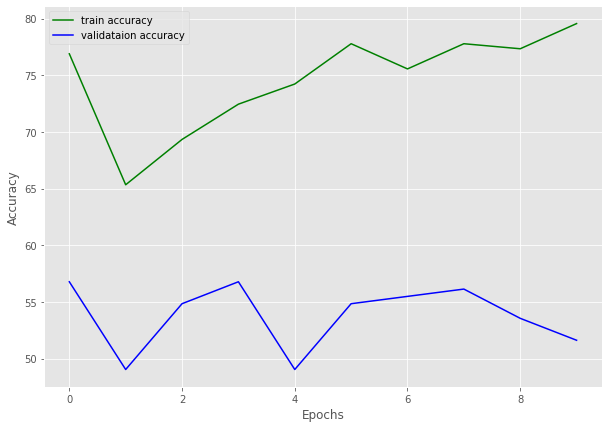

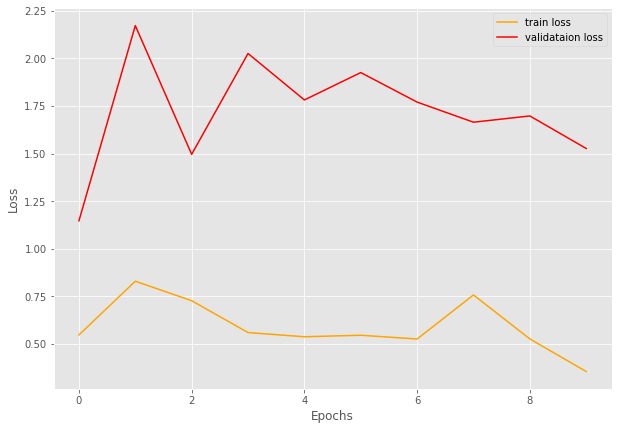

In [ ]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Master UNIR/TFM/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Master UNIR/TFM/loss.png')

matplotlib.style.use('ggplot')

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '/content/drive/My Drive/Master UNIR/TFM/model.pth')


# learning_parameters 
epochs = 10
print(f"Computation device: {device}\n")
model = model_transfer
print(model)

# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.06, momentum=0.9)

# loss function
criterion = nn.CrossEntropyLoss()

# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, validation_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)
    
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

Dataset DatasetFolder
    Number of datapoints: 25
    Root location: /content/drive/My Drive/Master UNIR/TFM/test_images/
    StandardTransform
Transform: Compose(
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
               Grayscale(num_output_channels=3)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


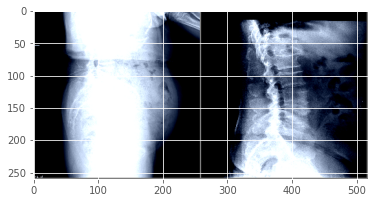

Accuracy for class: Calcification is 73.3 %
Accuracy for class: No Calcification is 70.0 %


In [ ]:
test_rx_data = datasets.DatasetFolder("/content/drive/My Drive/Master UNIR/TFM/test_images/", transform=transform_rx, loader=image_loader, extensions=(''))
print(test_rx_data)

test_loader = DataLoader(
    test_rx_data, batch_size=2, shuffle=True,
    num_workers=2, pin_memory=True
)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, _ = dataiter.next()

labels = test_rx_data.targets
classes = ('Calcification', 'No Calcification')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# print images
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      # initialize the model and load the trained weights
      # model = XRCalcifiedNet().to(device)
      model = model_transfer.to(device)
      checkpoint = torch.load('/content/drive/My Drive/Master UNIR/TFM/model.pth', map_location=device)
      model.load_state_dict(checkpoint['model_state_dict'])
      model.eval()

      outputs = model(images)
      _, predictions = torch.max(outputs, 1)

      for label, prediction in zip(labels, predictions):
        if label == prediction:
          correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')